[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Extracting aclImdb_v1.tar.gz to ....
Extraction completed!
Loading training data...
Loading test data...
Training data shape: (25000, 2)
Test data shape: (25000, 2)
Cleaning text data...
Generating word clouds...


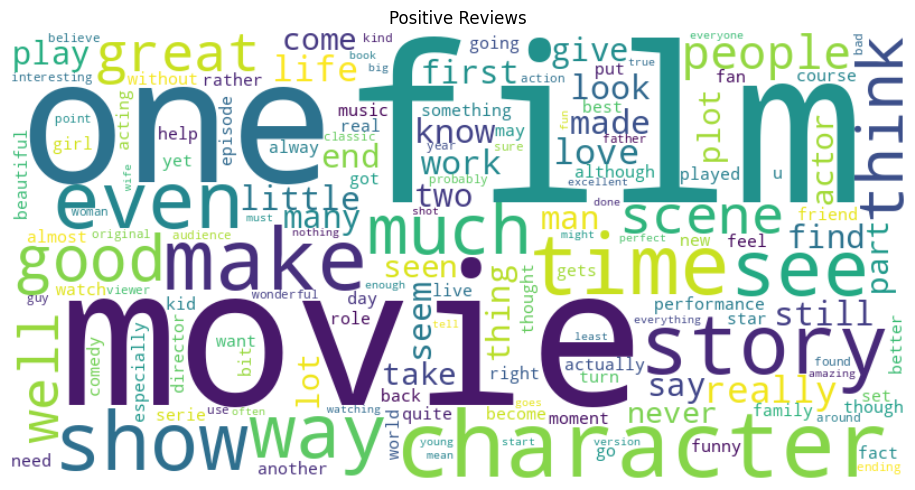

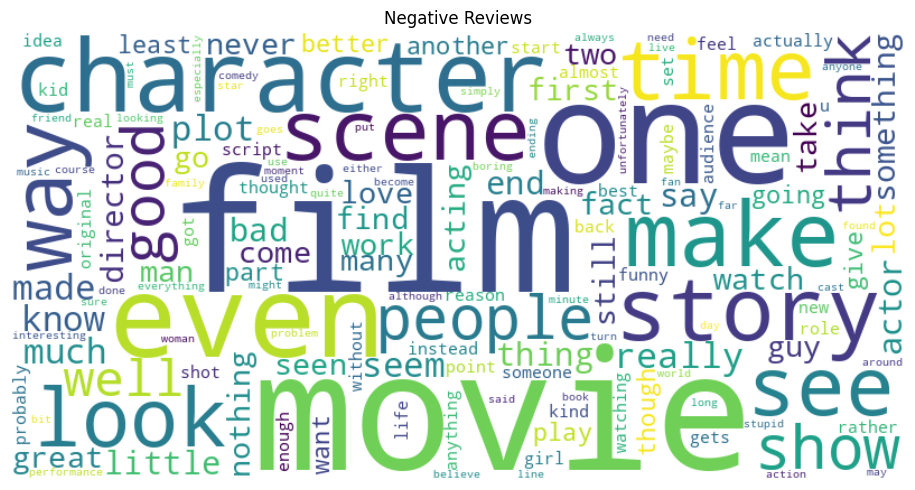

Extracting features with TF-IDF...
Training logistic regression model...
Making predictions...
Accuracy: 0.8834

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Top negative sentiment words:
worst, bad, waste, awful, boring, poor, nothing, worse, terrible, poorly

Top positive sentiment words:
love, loved, well, favorite, amazing, wonderful, perfect, best, excellent, great


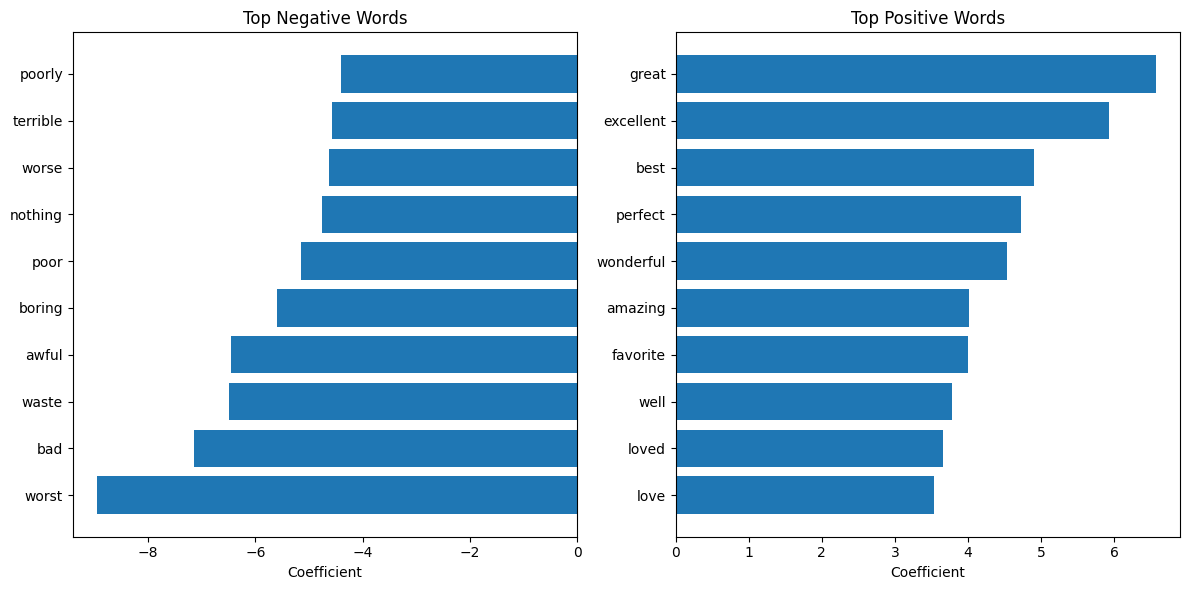


Sample review: This movie was fantastic! Great acting and an amazing storyline.
Predicted sentiment: Positive

Sample review: Terrible film. Bad acting and boring plot.
Predicted sentiment: Negative


In [2]:
import os
import re
import tarfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Download NLTK resources (if needed)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def extract_dataset(tar_path, extract_path='.'):
    """Extract the IMDb dataset from tar.gz file."""
    print(f"Extracting {tar_path} to {extract_path}...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction completed!")

def clean_text(text):
    """Clean and preprocess text data."""
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-letters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Convert to lowercase and split
    words = text.lower().split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def load_dataset(dataset_path):
    """Load IMDb dataset into pandas DataFrame."""
    reviews = []
    labels = []

    # Load positive reviews
    pos_path = os.path.join(dataset_path, 'pos')
    for filename in os.listdir(pos_path):
        if filename.endswith('.txt'):
            with open(os.path.join(pos_path, filename), 'r', encoding='utf-8') as f:
                reviews.append(f.read())
                labels.append(1)  # Positive label

    # Load negative reviews
    neg_path = os.path.join(dataset_path, 'neg')
    for filename in os.listdir(neg_path):
        if filename.endswith('.txt'):
            with open(os.path.join(neg_path, filename), 'r', encoding='utf-8') as f:
                reviews.append(f.read())
                labels.append(0)  # Negative label

    return pd.DataFrame({'review': reviews, 'sentiment': labels})

def create_wordcloud(texts, title):
    """Generate and display wordcloud for a set of texts."""
    all_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=150).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def main():
    tar_path = 'aclImdb_v1.tar.gz'
    extract_path = '.'

    # Extract dataset if needed
    if not os.path.exists(os.path.join(extract_path, 'aclImdb')):
        extract_dataset(tar_path, extract_path)

    # Define paths
    train_path = os.path.join(extract_path, 'aclImdb', 'train')
    test_path = os.path.join(extract_path, 'aclImdb', 'test')

    print("Loading training data...")
    train_df = load_dataset(train_path)
    print("Loading test data...")
    test_df = load_dataset(test_path)

    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")

    # Data preprocessing
    print("Cleaning text data...")
    train_df['cleaned_review'] = train_df['review'].apply(clean_text)
    test_df['cleaned_review'] = test_df['review'].apply(clean_text)

    # Create visualization
    print("Generating word clouds...")
    create_wordcloud(train_df[train_df['sentiment'] == 1]['cleaned_review'], 'Positive Reviews')
    create_wordcloud(train_df[train_df['sentiment'] == 0]['cleaned_review'], 'Negative Reviews')

    # Feature extraction using TF-IDF
    print("Extracting features with TF-IDF...")
    vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.8)
    X_train = vectorizer.fit_transform(train_df['cleaned_review'])
    X_test = vectorizer.transform(test_df['cleaned_review'])

    y_train = train_df['sentiment']
    y_test = test_df['sentiment']

    # Train classifier
    print("Training logistic regression model...")
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    y_pred = classifier.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Extract feature importance
    feature_names = np.array(vectorizer.get_feature_names_out())
    importance = np.abs(classifier.coef_[0])

    # Find top positive and negative words
    indices = np.argsort(classifier.coef_[0])
    top_negative = feature_names[indices[:10]]
    top_positive = feature_names[indices[-10:]]

    print("Top negative sentiment words:")
    print(", ".join(top_negative))

    print("\nTop positive sentiment words:")
    print(", ".join(top_positive))

    # Plot feature importance
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(top_negative, classifier.coef_[0][indices[:10]])
    plt.title('Top Negative Words')
    plt.xlabel('Coefficient')

    plt.subplot(1, 2, 2)
    plt.barh(top_positive, classifier.coef_[0][indices[-10:]])
    plt.title('Top Positive Words')
    plt.xlabel('Coefficient')

    plt.tight_layout()
    plt.show()

    # Function to predict sentiment for new reviews
    def predict_sentiment(review_text):
        cleaned = clean_text(review_text)
        vectorized = vectorizer.transform([cleaned])
        prediction = classifier.predict(vectorized)[0]
        sentiment = "Positive" if prediction == 1 else "Negative"
        return sentiment

    # Example usage
    sample_review = "This movie was fantastic! Great acting and an amazing storyline."
    print(f"\nSample review: {sample_review}")
    print(f"Predicted sentiment: {predict_sentiment(sample_review)}")

    sample_review2 = "Terrible film. Bad acting and boring plot."
    print(f"\nSample review: {sample_review2}")
    print(f"Predicted sentiment: {predict_sentiment(sample_review2)}")

if __name__ == "__main__":
    main()